# Pyspark & Astrophysical data: IMAGE

Let's play with Image. In this example, we load an image data from a FITS file (CFHTLens), and identify sources with a simple astropy algorithm. The workflow is described below. For simplicity, we only focus on one CCD in this notebook. For full scale, see the pyspark [im2cat.py](https://github.com/astrolabsoftware/spark-fits/blob/v0.4.0/examples/python/im2cat.py) script.

![im2cat](im2cat.jpg)

In [1]:
## Import SparkSession from Spark
from pyspark.sql import SparkSession

In [2]:
## Create a DataFrame from the HDU data of a FITS file
fn = "../../src/test/resources/image.fits"
hdu = 1
df = spark.read.format("com.sparkfits").option("hdu", hdu).load(fn)

In [3]:
## By default, spark-fits distributes the rows of the image
df.printSchema()
df.show(5)

root
 |-- Image: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+
|               Image|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



# Find objects on CCD

In [4]:
## In order to work on the full image, one needs to 
## re-partition the image by gathering all rows.
## For simplicity, we work with only one image, but in real life
## we would just have all CCDs distributed, one per Spark mapper.
## For a real life example, see the full example at spark-fits/example/python/im2cat.py

def rowdf_into_imagerdd(df, final_num_partition=1):
    """
    Reshape a DataFrame of rows into a RDD containing the full image
    in one partition.

    Parameters
    ----------
    df : DataFrame
        DataFrame of image rows.
    final_num_partition : Int
        The final number of partitions. Must be one (default) unless you
        know what you are doing.

    Returns
    ----------
    imageRDD : RDD
        RDD containing the full image in one partition
    """
    return df.rdd.coalesce(final_num_partition).glom()

imRDD = rowdf_into_imagerdd(df, 1)

In [5]:
## Let's run a simple object finder on our image,
## and collect the catalog.
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def reshape_image(im):
    """
    By default, Spark shapes images into (nx, 1, ny).
    This routine reshapes images into (nx, ny)

    Parameters
    ----------
    im : 3D array
        Original image with shape (nx, 1, ny)

    Returns
    ----------
    im_reshaped : 2D array
        Original image with shape (nx, ny)

    """
    shape = np.shape(im)
    return im.reshape((shape[0], shape[2]))

def get_stat(data, sigma=3.0, iters=3):
    """
    Estimate the background and background noise using
    sigma-clipped statistics.

    Parameters
    ----------
    data : 2D array
        2d array containing the data.
    sigma : float
        sigma.
    iters : int
        Number of iteration to perform to get accurate estimate.
        The higher the better, but it will be longer.
    """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma, iters=iters)
    return mean, median, std

## Source detection: build the catalogs for each CCD in parallel
## Only one CCD in this example.
cat = imRDD.map(
    lambda im: reshape_image(np.array(im)))\
    .map(
        lambda im: (im, get_stat(im)))\
    .map(
        lambda im_stat: (
            im_stat[0],
            im_stat[1][1],
            DAOStarFinder(fwhm=3.0, threshold=5.*im_stat[1][2])))\
    .map(
        lambda im_mean_starfinder: im_mean_starfinder[2](
            im_mean_starfinder[0] - im_mean_starfinder[1]))
    
final_cat = cat.collect()
print(final_cat)

[<Table length=289>
  id    xcentroid     ycentroid   ...   peak       flux            mag       
int64    float64       float64    ... float64    float64         float64     
----- ------------- ------------- ... ------- ------------- -----------------
    1 1319.44071378 2.43214243687 ...   -13.0 3.59255287043    -1.38850792056
    2 1574.55608386 2.46469410645 ...   -10.0 3.79822025391    -1.44895036327
    3  1629.4590588 2.47568342366 ...     8.0 3.59194749857    -1.38832495052
    4 1770.43547085 39.0725933865 ...   215.0 2.07593583361   -0.793034813766
    5 2003.25123784 41.4644987786 ...   872.0 1.27179642825   -0.261044002407
    6 2002.37039206 41.5756420701 ...   726.0 1.23007125287   -0.224825672568
    7 2013.23942874 44.7874971464 ...   326.0 1.00623992119 -0.00675385842248
    8 422.290201312 108.059189316 ...   653.0 4.83291454543    -1.71052279026
    9 272.248719186 127.900414086 ...   702.0 4.68228148159    -1.67614379584
   10 1456.49773046 129.927458225 ...  1868.

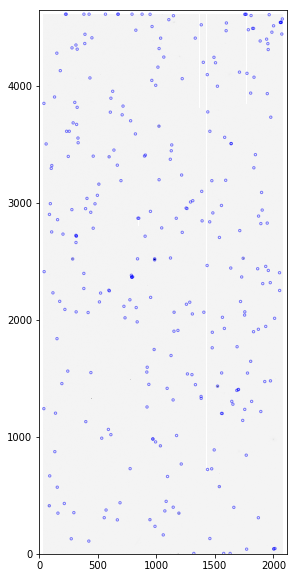

In [6]:
## Let's visualise our objects found
from astropy.io import fits
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as pl

## Grab initial data for plot
data = fits.open(fn)
data = data[hdu].data

## Plot the result on top of the CCD
fig = pl.figure(0, (10, 10))

positions = (
    final_cat[hdu-1]['xcentroid'], 
    final_cat[hdu-1]['ycentroid'])
apertures = CircularAperture(positions, r=10.)
norm = ImageNormalize(stretch=SqrtStretch())
pl.imshow(data, cmap='Greys', origin="lower", norm=norm)
apertures.plot(color='blue', lw=1.0, alpha=0.5)

pl.show()

In [7]:
## Of course, one could use different algorithms, like the ones in the Stack!